In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
import numpy as np
from scipy import stats

### Read inputs and process

In [2]:
benzene_quints = []
free_quints = []
bound_quints = []

# quintuplicates provided by Cresset. FEP+/JACS set.
with open("compiled_mbar_freenrgs_cresset_jacs.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        if "free" in row[0]:
            free_quints.append([row[0].replace("mcl","mcl1"), row[-1]])
        elif "bound" in row[0]:
            bound_quints.append([row[0].replace("mcl","mcl1"), row[-1]])

# quintuplicates run in-house. Merck set.
with open("compiled_mbar_freenrgs_jscheen_merck.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        if "free" in row[0]:
            free_quints.append([row[0], row[-1]])
        elif "bound" in row[0]:
            bound_quints.append([row[0], row[-1]])
            
# quintuplicates run in-house. FEP-space set. Should match the perturbations in the above two files.
with open("compiled_mbar_freenrgs_fepspace.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        benzene_quints.append([row[0].replace("lig_", ""), row[-1]])


In [3]:
def returnInfo(input_list):
    """given a nested list, return the perturbations, targets and SEMs as arrays."""
    
    pert_names = []
    targets = []
    sems = []
    
    for row in input_list:
        # just some convoluted conditionals to deal with inconsistent ligand naming.
        if len(row[0].split("_")) >= 3:
            pert_name = "_".join(row[0].split("_")[:-2])
        else:
            pert_name = row[0].split("_")[0]
            
        if "free" in row[0] or "bound" in row[0]:    
            target = row[0].split("_")[-2]
        else:
            target = row[0].split("_")[-1]

        sem = float(row[1])
        
        pert_names.append(pert_name)
        targets.append(target)
        sems.append(sem)
        

    return pert_names, targets, sems

In [4]:
perts_benz, tgts_benz, sems_benz = returnInfo(benzene_quints)
perts_b, tgts_b, sems_b = returnInfo(free_quints)
perts_free, tgts_free, sems_free = returnInfo(bound_quints)

In [5]:
benz_df = pd.DataFrame.from_items([("pert", perts_benz),
                          ("tgt", tgts_benz),
                          ("sem_benz", sems_benz)
                          ])
b_df = pd.DataFrame.from_items([("pert", perts_b),
                          ("tgt", tgts_b),
                          ("sem_b", sems_b)
                          ])
free_df = pd.DataFrame.from_items([("pert", perts_free),
                          ("tgt", tgts_free),
                          ("sem_free", sems_free)
                          ])


<ipython-input-5-40698f138d35>:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  benz_df = pd.DataFrame.from_items([("pert", perts_benz),
<ipython-input-5-40698f138d35>:5: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  b_df = pd.DataFrame.from_items([("pert", perts_b),
<ipython-input-5-40698f138d35>:9: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  free_df = pd.DataFrame.from_items([("pert", perts_free),


In [6]:
two_df = pd.merge(benz_df, b_df, how='left', on=['pert', 'tgt'])

full_df = pd.merge(two_df, free_df, how='left', on=['pert', 'tgt']).dropna()

## Plot 

Total number of perturbations: 145


/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

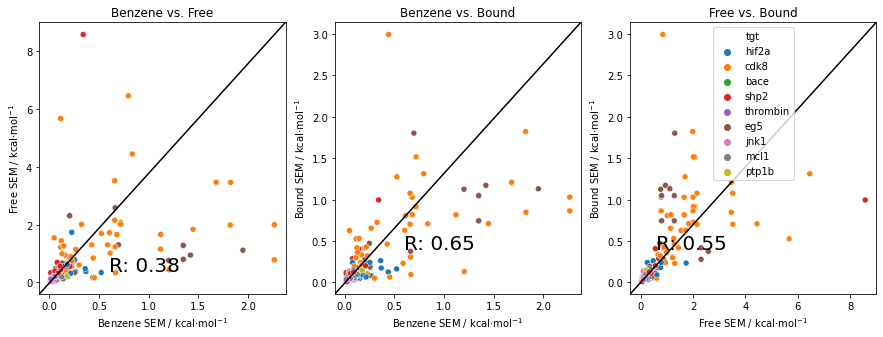

In [7]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

print("Total number of perturbations:", len(full_df["sem_benz"]))
#######

sns.scatterplot("sem_benz", "sem_free", data=full_df, hue="tgt", ax=axes[0])
axes[0].set_title("Benzene vs. Free")

_, _, r_value, _, _ = stats.linregress(full_df["sem_benz"], full_df["sem_free"])
axes[0].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)


#######
sns.scatterplot("sem_benz", "sem_b", data=full_df, hue="tgt", ax=axes[1])
axes[1].set_title("Benzene vs. Bound")

_, _, r_value, _, _ = stats.linregress(full_df["sem_benz"], full_df["sem_b"])
axes[1].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)

#######
sns.scatterplot("sem_free", "sem_b", data=full_df, hue="tgt", ax=axes[2])
axes[2].set_title("Free vs. Bound")

_, _, r_value, _, _ = stats.linregress(full_df["sem_free"], full_df["sem_b"])
axes[2].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20)

#######

for ax in axes:
#     ax.set_ylim(0, 1)
#     ax.set_xlim(0, 1)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black")
    
axes[0].set_ylabel("Free SEM / kcal$\cdot$mol$^{-1}$")
axes[1].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")
axes[2].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")

axes[0].set_xlabel("Benzene SEM / kcal$\cdot$mol$^{-1}$")
axes[1].set_xlabel("Benzene SEM / kcal$\cdot$mol$^{-1}$")
axes[2].set_xlabel("Free SEM / kcal$\cdot$mol$^{-1}$")
axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
plt.show()

## Repeat but exclude SEM > 0.5 kcal/mol

Total number of perturbations: 73


/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jscheen/miniconda3/envs/HYDRA/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

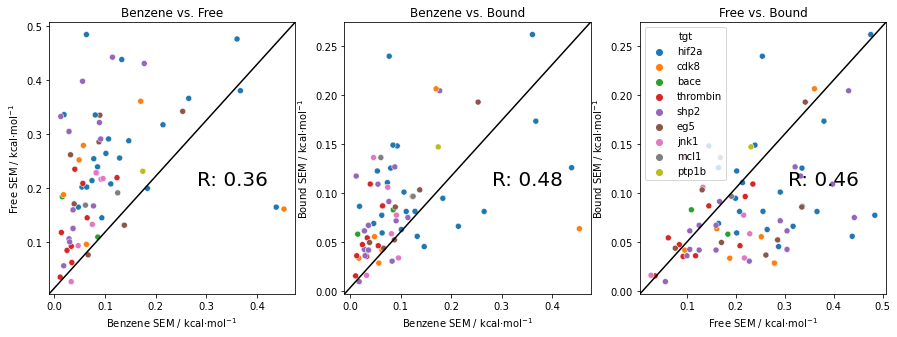

In [8]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
excluded_df = full_df[full_df["sem_benz"] < 0.5]
excluded_df = excluded_df[excluded_df["sem_b"] < 0.5]
excluded_df = excluded_df[excluded_df["sem_free"] < 0.5]

print("Total number of perturbations:", len(excluded_df["sem_benz"]))

#######

sns.scatterplot("sem_benz", "sem_free", data=excluded_df, hue="tgt", ax=axes[0])
axes[0].set_title("Benzene vs. Free")

_, _, r_value, _, _ = stats.linregress(excluded_df["sem_benz"], excluded_df["sem_free"])
axes[0].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20, xycoords="axes fraction")


#######
sns.scatterplot("sem_benz", "sem_b", data=excluded_df, hue="tgt", ax=axes[1])
axes[1].set_title("Benzene vs. Bound")

_, _, r_value, _, _ = stats.linregress(excluded_df["sem_benz"], excluded_df["sem_b"])
axes[1].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20, xycoords="axes fraction")

#######
sns.scatterplot("sem_free", "sem_b", data=excluded_df, hue="tgt", ax=axes[2])
axes[2].set_title("Free vs. Bound")

_, _, r_value, _, _ = stats.linregress(excluded_df["sem_free"], excluded_df["sem_b"])
axes[2].annotate(text="R: "+str(round(r_value, 2)), xy=(0.6, 0.4), size=20, xycoords="axes fraction")

#######

for ax in axes:
#     ax.set_ylim(0, 1)
#     ax.set_xlim(0, 1)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black")
    
axes[0].set_ylabel("Free SEM / kcal$\cdot$mol$^{-1}$")
axes[1].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")
axes[2].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")

axes[0].set_xlabel("Benzene SEM / kcal$\cdot$mol$^{-1}$")
axes[1].set_xlabel("Benzene SEM / kcal$\cdot$mol$^{-1}$")
axes[2].set_xlabel("Free SEM / kcal$\cdot$mol$^{-1}$")
axes[0].legend([],[], frameon=False)
axes[1].legend([],[], frameon=False)
plt.show()

# Now colour by num_ha_perturbed

In [9]:
num_ha_array = []
for idx, line in full_df[["pert", "tgt"]].iterrows():
    added = False
    with open("./fepspace_perts.csv", "r") as fepspace_info:
        reader = csv.reader(fepspace_info)
        for row in reader:
            if row[0] == line["pert"] and row[1] == line["tgt"]:
                num_ha_array.append(int(row[2]))
                added = True
                
                
    if not added:
        with open("./fepspace_perts.csv", "r") as fepspace_info:           
            reader = csv.reader(fepspace_info)
            next(reader)
            for row in reader:
                new_pert_name = "lig_"+row[0].split("~")[0]+"~lig_"+row[0].split("~")[1]

                if new_pert_name == line["pert"] and row[1] == line["tgt"]:
                    num_ha_array.append(int(row[2]))
                    added = True
    if not added:
        full_df.drop(idx, inplace=True)
            

In [10]:
full_df["num_ha_perturbed"] = num_ha_array

In [11]:
import matplotlib as mpl

In [12]:
full_df.sort_values(by="num_ha_perturbed").tail(1)

,pert,tgt,sem_benz,sem_b,sem_free,num_ha_perturbed
36,CHEMBL1078774~CHEMBL1093088,eg5,1.201159,1.123926,0.761543,10


Total number of perturbations: 125


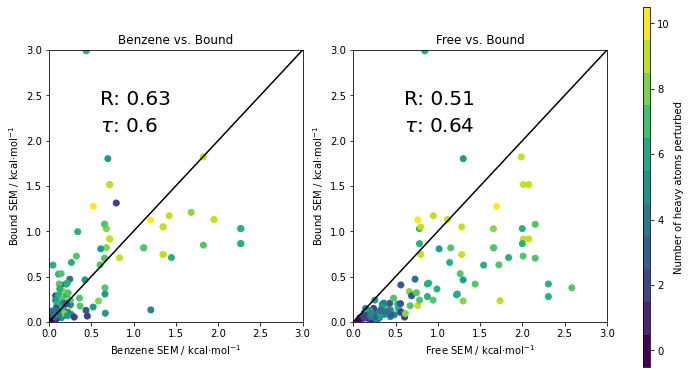

In [20]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
print("Total number of perturbations:", len(full_df["sem_benz"]))
#######
#######

axes[0].scatter(full_df["sem_benz"], full_df["sem_b"], c=full_df["num_ha_perturbed"])
axes[0].set_title("Benzene vs. Bound")

_, _, r_value, _, _ = stats.linregress(full_df["sem_benz"], full_df["sem_b"])
tau, _ = stats.kendalltau(full_df["sem_benz"], full_df["sem_b"])
axes[0].annotate(text="R: "+str(round(r_value, 2)), xy=(0.2, 0.8), size=20, xycoords="axes fraction")
axes[0].annotate(text=r"$\tau$: "+str(round(tau, 2)), xy=(0.2, 0.7), size=20, xycoords="axes fraction")

#######
axes[1].scatter(full_df["sem_free"], full_df["sem_b"], c=full_df["num_ha_perturbed"])
axes[1].set_title("Free vs. Bound")

_, _, r_value, _, _ = stats.linregress(full_df["sem_free"], full_df["sem_b"])
tau, _ = stats.kendalltau(full_df["sem_free"], full_df["sem_b"])
axes[1].annotate(text="R: "+str(round(r_value, 2)), xy=(0.2, 0.8), size=20, xycoords="axes fraction")
axes[1].annotate(text=r"$\tau$: "+str(round(tau, 2)), xy=(0.2, 0.7), size=20, xycoords="axes fraction")

#######

for ax in axes:
    ax.set_ylim(0, 3)
    ax.set_xlim(0, 3)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black")


axes[0].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")
axes[1].set_ylabel("Bound SEM / kcal$\cdot$mol$^{-1}$")


axes[0].set_xlabel("Benzene SEM / kcal$\cdot$mol$^{-1}$")
axes[1].set_xlabel("Free SEM / kcal$\cdot$mol$^{-1}$")



ax = fig.add_axes([0.95, 0, 0.01, 1])

cb = mpl.colorbar.ColorbarBase(ax, values=np.arange(0,11), label="Number of heavy atoms perturbed")

plt.show()